In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, RocCurveDisplay
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
df = pd.read_csv('../data/creditcard.csv')
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


# Classes are imbalanced due to nature of fraud cases
# 0 = Non fraud, 1 = fraud

In [4]:
df.value_counts('Class')

Class
0    284315
1       492
Name: count, dtype: int64

In [5]:
X = df.drop(['Class','Time'], axis=1)
y = df['Class']

In [6]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,   # 20% test, 80% train
    random_state=42, # ensures reproducibility
    stratify=y       # keeps the same fraud/non-fraud ratio in train and test
)

In [7]:
# Initialize and train the XGBoost model
xgb = XGBClassifier(
    n_estimators=100,    # number of trees
    max_depth=4,         # max depth of each tree
    learning_rate=0.1,   # learning rate
    random_state=42,     # for reproducibility
    scale_pos_weight=len(y_train[y_train==0])/len(y_train[y_train==1])  # handle class imbalance
)

# Train the model
xgb.fit(X_train, y_train)

,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [8]:
# Make predictions on test set
y_pred = xgb.predict(X_test)

# Get classification report as a dict and convert to DataFrame
report = classification_report(y_test, y_pred, output_dict=True)
report_df = pd.DataFrame(report).transpose()

# Round the values to 3 decimal places for better readability
report_df = report_df.round(3)

# Display the DataFrame
report_df

,precision,recall,f1-score,support
0,1.000,0.997,0.998,56864.000
1,0.318,0.857,0.464,98.000
accuracy,0.997,0.997,0.997,0.997
macro avg,0.659,0.927,0.731,56962.000
weighted avg,0.999,0.997,0.997,56962.000


# Threshold at 0.5

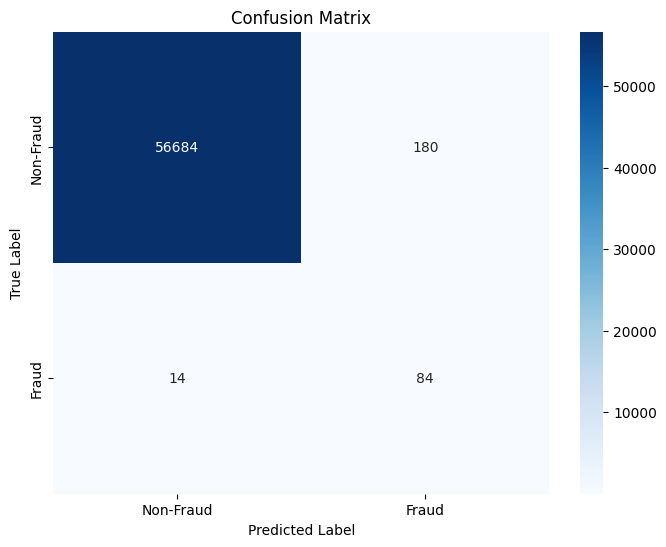


Confusion Matrix Raw Numbers:
True Negatives: 56684
False Positives: 180
False Negatives: 14
True Positives: 84


In [29]:
# Create confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Create a prettier confusion matrix visualization
plt.figure(figsize=(8, 6))
sns.heatmap(cm,
            annot=True,           # Show numbers in cells
            fmt='g',              # Format numbers as integers
            cmap='Blues',         # Blue color scheme
            xticklabels=['Non-Fraud', 'Fraud'],
            yticklabels=['Non-Fraud', 'Fraud'])

plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Print raw numbers
print("\nConfusion Matrix Raw Numbers:")
print(f"True Negatives: {cm[0,0]}")
print(f"False Positives: {cm[0,1]}")
print(f"False Negatives: {cm[1,0]}")
print(f"True Positives: {cm[1,1]}")

<Figure size 1300x700 with 0 Axes>

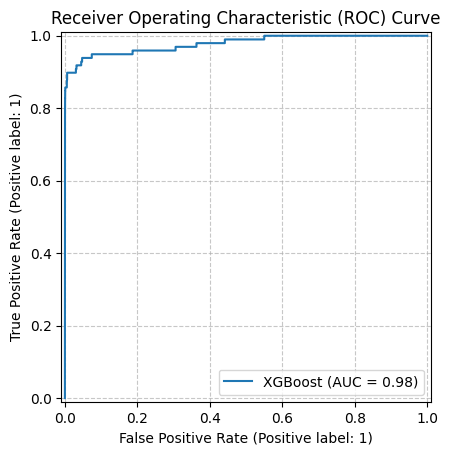

In [34]:
# Plot ROC curve
plt.figure(figsize=(13, 7))  # Increase figure size
roc_display = RocCurveDisplay.from_estimator(
    xgb,
    X_test,
    y_test,
    name='XGBoost'
)
plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

/home/chinung/.pyenv/versions/3.12.9/envs/lewagon/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


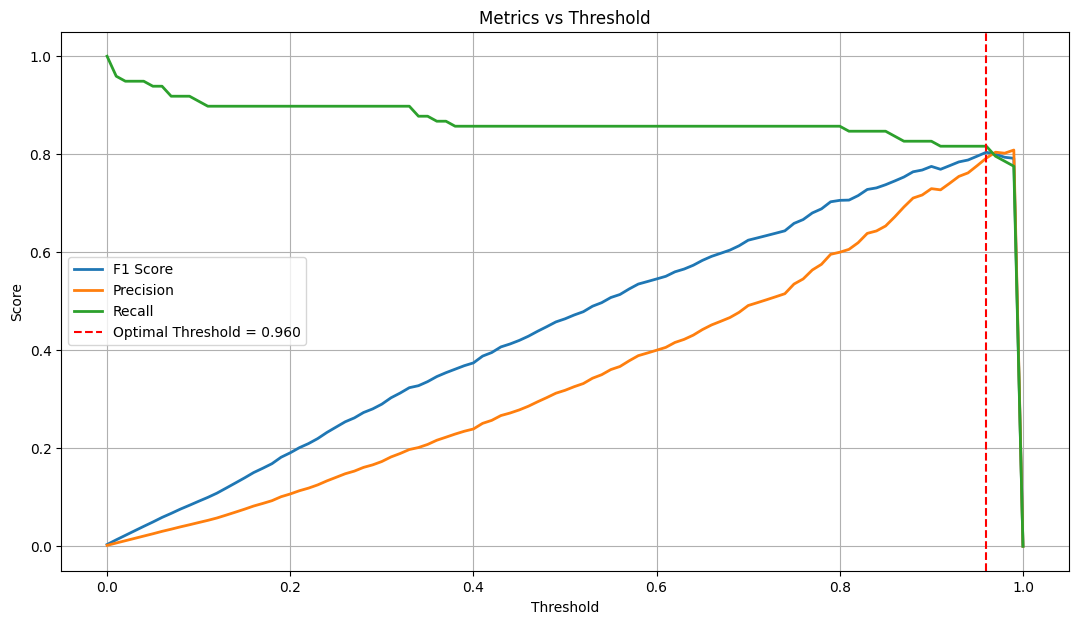

Optimal Threshold: 0.960
Best F1 Score: 0.804

Original F1 Score (threshold=0.5): 0.464

Classification Report with Optimal Threshold:
              precision  recall  f1-score    support
0                 1.000   1.000     1.000  56864.000
1                 0.792   0.816     0.804     98.000
accuracy          0.999   0.999     0.999      0.999
macro avg         0.896   0.908     0.902  56962.000
weighted avg      0.999   0.999     0.999  56962.000


In [9]:
# Get prediction probabilities
y_pred_proba = xgb.predict_proba(X_test)[:, 1]

# Create arrays for different threshold values
thresholds = np.arange(0, 1.01, 0.01)
f1_scores = []
precision_scores = []
recall_scores = []

# Calculate F1 score for each threshold
from sklearn.metrics import f1_score, precision_score, recall_score

for threshold in thresholds:
    y_pred_threshold = (y_pred_proba >= threshold).astype(int)
    f1_scores.append(f1_score(y_test, y_pred_threshold))
    precision_scores.append(precision_score(y_test, y_pred_threshold))
    recall_scores.append(recall_score(y_test, y_pred_threshold))

# Find the optimal threshold
optimal_idx = np.argmax(f1_scores)
optimal_threshold = thresholds[optimal_idx]
optimal_f1 = f1_scores[optimal_idx]

# Plot the results
plt.figure(figsize=(13, 7))
plt.plot(thresholds, f1_scores, label='F1 Score', linewidth=2)
plt.plot(thresholds, precision_scores, label='Precision', linewidth=2)
plt.plot(thresholds, recall_scores, label='Recall', linewidth=2)
plt.axvline(x=optimal_threshold, color='r', linestyle='--', label=f'Optimal Threshold = {optimal_threshold:.3f}')
plt.grid(True)
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Metrics vs Threshold')
plt.legend()
plt.show()

# Print the results
print(f"Optimal Threshold: {optimal_threshold:.3f}")
print(f"Best F1 Score: {optimal_f1:.3f}")

# Compare with original threshold (0.5) results
original_f1 = f1_score(y_test, (y_pred_proba >= 0.5).astype(int))
print(f"\nOriginal F1 Score (threshold=0.5): {original_f1:.3f}")

# Show predictions with optimal threshold
y_pred_optimal = (y_pred_proba >= optimal_threshold).astype(int)
print("\nClassification Report with Optimal Threshold:")
report_optimal = classification_report(y_test, y_pred_optimal, output_dict=True)
report_optimal_df = pd.DataFrame(report_optimal).transpose().round(3)
print(report_optimal_df)

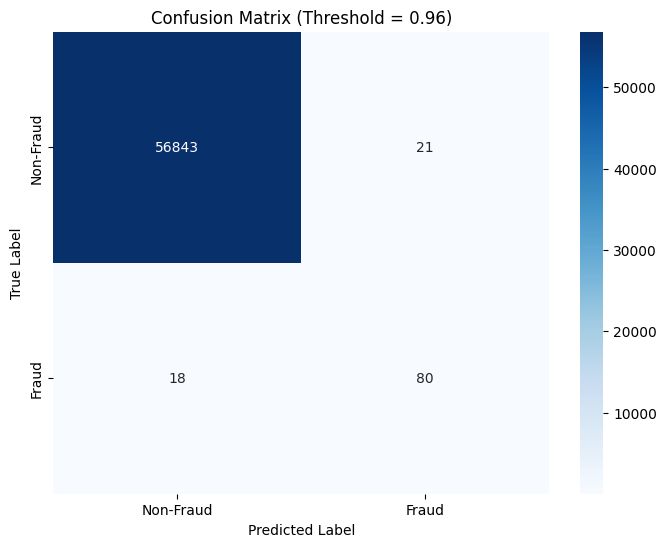


Confusion Matrix Raw Numbers:
True Negatives: 56843
False Positives: 21
False Negatives: 18
True Positives: 80

Performance Metrics at threshold 0.96:
Precision: 0.792
Recall: 0.816
F1 Score: 0.804


In [37]:
# Create predictions with threshold 0.96
threshold = 0.96
y_pred_new = (y_pred_proba >= threshold).astype(int)

# Calculate confusion matrix
cm_new = confusion_matrix(y_test, y_pred_new)

# Create visualization
plt.figure(figsize=(8, 6))
sns.heatmap(cm_new,
            annot=True,           # Show numbers in cells
            fmt='g',              # Format numbers as integers
            cmap='Blues',         # Blue color scheme
            xticklabels=['Non-Fraud', 'Fraud'],
            yticklabels=['Non-Fraud', 'Fraud'])

plt.title(f'Confusion Matrix (Threshold = {threshold})')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Print raw numbers
print("\nConfusion Matrix Raw Numbers:")
print(f"True Negatives: {cm_new[0,0]}")
print(f"False Positives: {cm_new[0,1]}")
print(f"False Negatives: {cm_new[1,0]}")
print(f"True Positives: {cm_new[1,1]}")

# Print performance metrics
precision = precision_score(y_test, y_pred_new)
recall = recall_score(y_test, y_pred_new)
f1 = f1_score(y_test, y_pred_new)

print(f"\nPerformance Metrics at threshold {threshold}:")
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1 Score: {f1:.3f}")

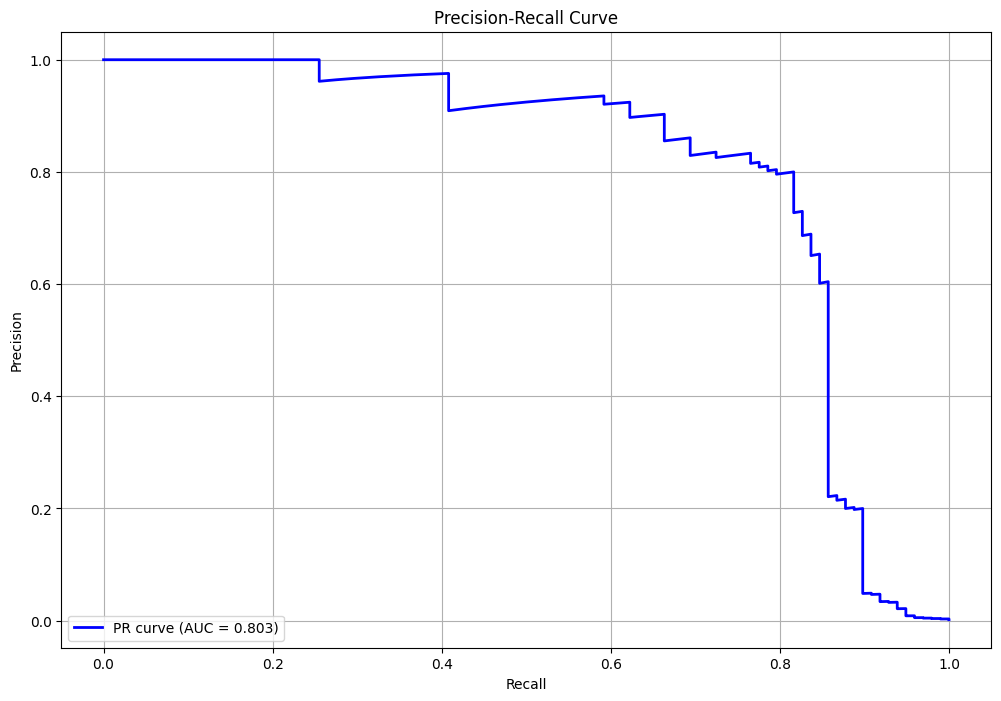

Precision-Recall AUC: 0.803


In [39]:
# Import required metrics
from sklearn.metrics import precision_recall_curve, auc, roc_curve

# Calculate Precision-Recall curve
precision, recall, pr_thresholds = precision_recall_curve(y_test, y_pred_proba)
pr_auc = auc(recall, precision)

# Plot Precision-Recall curve
plt.figure(figsize=(12, 8))
plt.plot(recall, precision, color='blue', lw=2, label=f'PR curve (AUC = {pr_auc:.3f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.grid(True)
plt.legend(loc='lower left')
plt.show()

print(f"Precision-Recall AUC: {pr_auc:.3f}")

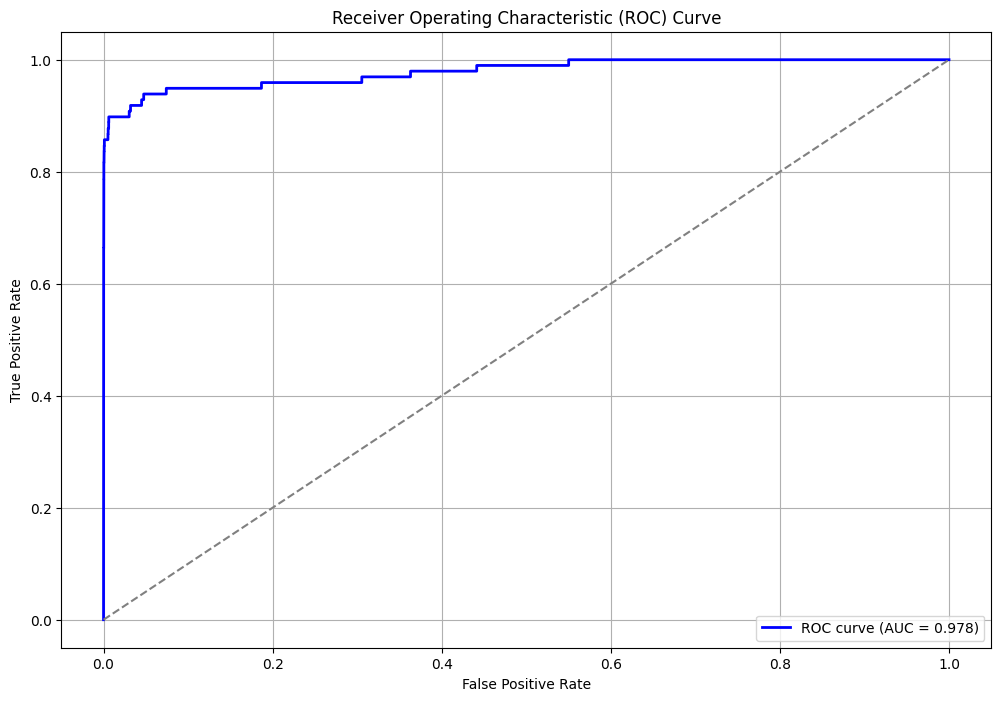

ROC AUC: 0.978


In [40]:
# Calculate ROC curve
fpr, tpr, roc_thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(12, 8))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.grid(True)
plt.legend(loc='lower right')
plt.show()

print(f"ROC AUC: {roc_auc:.3f}")

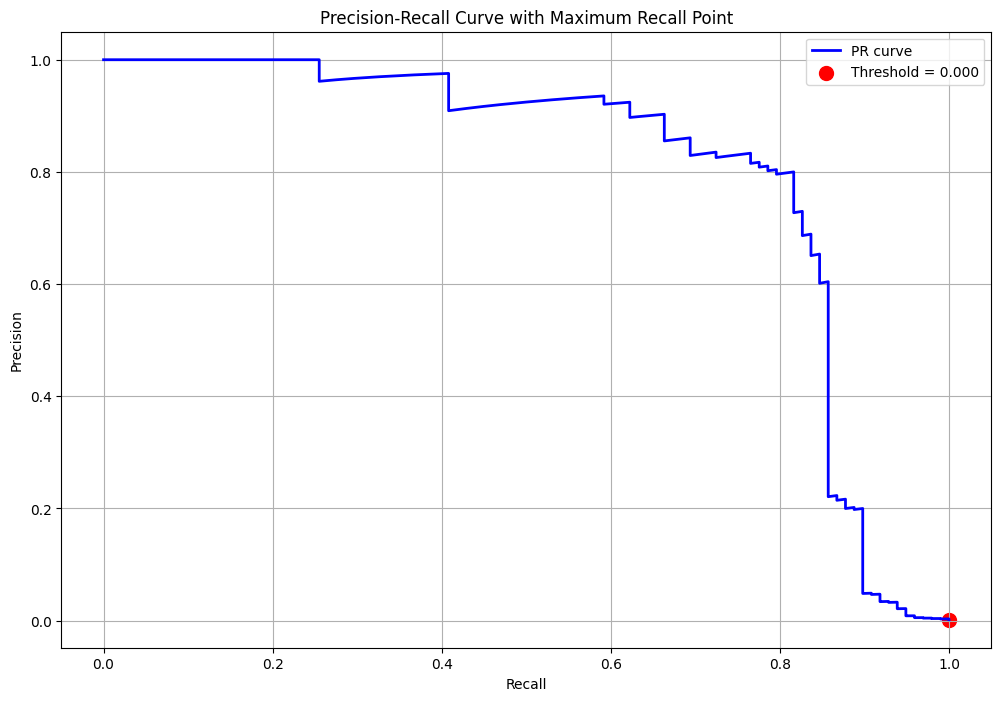

At threshold 0.000:
Precision: 0.002
Recall: 1.000
F1 Score: 0.003


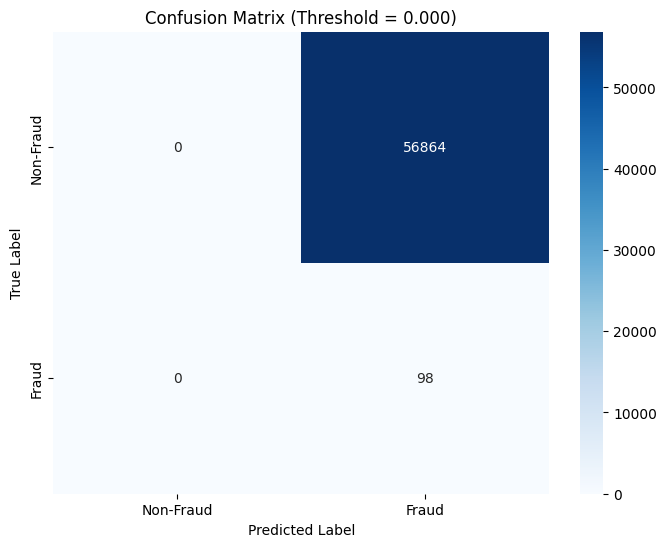

In [41]:
# Find threshold where recall is closest to 1
recall_1_idx = np.argmin(np.abs(recall - 1))
threshold_at_recall_1 = pr_thresholds[recall_1_idx]
precision_at_recall_1 = precision[recall_1_idx]
recall_value = recall[recall_1_idx]

# Plot Precision-Recall curve with the point where recall ≈ 1
plt.figure(figsize=(12, 8))
plt.plot(recall, precision, color='blue', lw=2, label='PR curve')
plt.scatter([recall_value], [precision_at_recall_1], color='red', s=100,
            label=f'Threshold = {threshold_at_recall_1:.3f}')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve with Maximum Recall Point')
plt.grid(True)
plt.legend()
plt.show()

# Print the metrics at this threshold
y_pred_recall_1 = (y_pred_proba >= threshold_at_recall_1).astype(int)
precision = precision_score(y_test, y_pred_recall_1)
recall = recall_score(y_test, y_pred_recall_1)
f1 = f1_score(y_test, y_pred_recall_1)

print(f"At threshold {threshold_at_recall_1:.3f}:")
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1 Score: {f1:.3f}")

# Show confusion matrix at this threshold
cm_recall_1 = confusion_matrix(y_test, y_pred_recall_1)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_recall_1,
            annot=True,
            fmt='g',
            cmap='Blues',
            xticklabels=['Non-Fraud', 'Fraud'],
            yticklabels=['Non-Fraud', 'Fraud'])

plt.title(f'Confusion Matrix (Threshold = {threshold_at_recall_1:.3f})')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [10]:
# Import joblib for model saving
from joblib import dump, load

# Save the model
model_path = 'xgboost_fraud_detector_22-9-2025.joblib'

# Save the model
dump(xgb, model_path)
print(f"Model saved to: {model_path}")

# Save the scaler if you used one (in this case we didn't use a scaler)
# If you need to use the model later, you can load it like this:
# loaded_model = load(model_path)
# y_pred = loaded_model.predict(X_test)

Model saved to: xgboost_fraud_detector_22-9-2025.joblib
